## TEST1

In [1]:
! pip install syft

     |████████████████████████████████| 225kB 3.4MB/s 
     |████████████████████████████████| 204kB 53.8MB/s 
     |████████████████████████████████| 460kB 59.9MB/s 
     |████████████████████████████████| 2.1MB 50.0MB/s 
     |████████████████████████████████| 81kB 35.7MB/s 
     |████████████████████████████████| 389kB 55.7MB/s 
     |████████████████████████████████| 256kB 56.6MB/s 
     |████████████████████████████████| 266kB 60.7MB/s 
     |████████████████████████████████| 51kB 20.1MB/s 
     |████████████████████████████████| 122kB 56.2MB/s 
  Created wheel for zstd: filename=zstd-1.4.1.0-cp36-cp36m-linux_x86_64.whl size=1067083 sha256=125e93c1103cbab5340d8477eaa8ca2f69be700e3f6366235b16cc41c6ffd36b
  Stored in directory: /root/.cache/pip/wheels/66/3f/ee/ac08c81af7c1b24a80c746df669ea3cb37542d27877d66ccf4
  Created wheel for pyyaml: filename=PyYAML-5.1.2-cp36-cp36m-linux_x86_64.whl size=44105 sha256=10d0c0672be0b57f87030abe83f708488974ddba9ec6171bf4f600f1f24bfa0d
  Stored in di

In [0]:
import torch
#torch.set_default_tensor_type(torch.cuda.FloatTensor)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [3]:
import syft as sy  # <-- NEW: import the Pysyft library
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker bob
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice

W0805 09:36:16.813091 140601580705664 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0805 09:36:16.825485 140601580705664 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



### SPLIT LEARNING CPU

In [0]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = True
        self.seed = 1
        self.log_interval = 30
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

#device = torch.device("cuda" if use_cuda else "cpu")
device = torch.device("cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [6]:
federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)


  0%|          | 16384/9912422 [00:00<01:28, 111689.59it/s]

9920512it [00:00, 29211926.35it/s]                           


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 450595.88it/s]
  1%|          | 16384/1648877 [00:00<00:11, 145218.91it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7234277.54it/s]                            
8192it [00:00, 183981.98it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.max_pool2d(x, 2, 2)

In [0]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
models = [Net1(),Net1()]
models[0] = models[0].send(bob)
models[1] = models[1].send(alice)


opt1 = optim.SGD(params=models[0].parameters(),lr=0.1)
opt2 = optim.SGD(params=models[1].parameters(),lr=0.1)

In [0]:
def train(args, model, device, federated_train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, targs) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        #IF ON DATA LOCATION TO GET THE RIGHT MODEL
        if data.location.id == 'bob':
          mod_c,opt_c = models[0], opt1
        else : 
          mod_c,opt_c = models[1], opt2
          
       # 1) erase previous gradients (if they exist)
        optimizer.step()
        opt_c.step()
        opt_c.zero_grad()
        optimizer.zero_grad()
        
        
        #model.send(data.location) # <-- NEW: send the model to the right location
        #target= tar.get()
        tg_copy = targs.copy()
        target = tg_copy.get()
        data, target = data.to(device), target.to(device)
        #optimizer.zero_grad()
        # 2) make a prediction until cut layer (client location)
        pred_c = mod_c(data)
        copy = pred_c.copy()
        # 3) get this to the server 
        inp = copy.get()

        # 4) make prediction with second part of the model (server location)
        pred = model(inp)

        # 5) calculate how much we missed 
        #print(pred.size(),target.size())
        loss = F.nll_loss(pred, target)
        loss.backward()
        
        gradient = inp.grad
        #print()
        gradient = gradient.view(inp.shape)
        G = gradient.send(data.location)
        #print(G.shape)
        #print(pred_c.shape)
        pred_c.backward(G)
        #print(data.grad)
        #target = target.send(data.location)
        #optimizer.step()
        #model.get() # <-- NEW: get the model back
        if batch_idx % args.log_interval == 0:
            #loss = loss.get() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
                100. * batch_idx / len(federated_train_loader), loss.item()))

In [0]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    M1 = models[0].copy()
    M2 = models[1].copy()
    M1 = M1.get()
    M2 = M2.get()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(M1(data))
            #output2 = model(M2(data))
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [12]:
%%time
model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment

for epoch in range(1, args.epochs + 1):
    train(args, model, device, federated_train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

if (args.save_model):
    torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60032 (0%)]	Loss: 2.312780
Train Epoch: 1 [1920/60032 (3%)]	Loss: 2.102405
Train Epoch: 1 [3840/60032 (6%)]	Loss: 1.226992
Train Epoch: 1 [5760/60032 (10%)]	Loss: 0.818510
Train Epoch: 1 [7680/60032 (13%)]	Loss: 0.420083
Train Epoch: 1 [9600/60032 (16%)]	Loss: 0.317328
Train Epoch: 1 [11520/60032 (19%)]	Loss: 0.342280
Train Epoch: 1 [13440/60032 (22%)]	Loss: 0.242250
Train Epoch: 1 [15360/60032 (26%)]	Loss: 0.291382
Train Epoch: 1 [17280/60032 (29%)]	Loss: 0.335301
Train Epoch: 1 [19200/60032 (32%)]	Loss: 0.238702
Train Epoch: 1 [21120/60032 (35%)]	Loss: 0.142208
Train Epoch: 1 [23040/60032 (38%)]	Loss: 0.229823
Train Epoch: 1 [24960/60032 (42%)]	Loss: 0.355077


KeyboardInterrupt: ignored

## TEST2

### INSTALLATION

In [1]:
! git clone https://github.com/OpenMined/PySyft.git

Cloning into 'PySyft'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 28164 (delta 25), reused 16 (delta 8), pack-reused 28106
Receiving objects: 100% (28164/28164), 31.90 MiB | 24.90 MiB/s, done.
Resolving deltas: 100% (18559/18559), done.


In [2]:
% cd PySyft

/content/PySyft


In [0]:
! git checkout d126b3110a3970bef8932ffaf8987ba77d32deb1 .

In [0]:
! git checkout 33f18dac67e9cc33e05c6698a5c48ad36de05755 .

In [4]:
% cd ..

/content


In [0]:
! mv native.py PySyft/syft/frameworks/torch/tensors/interpreters/

In [6]:
cd PySyft

/content/PySyft


In [7]:
! ls

CONTRIBUTING.md  INSTALLATION.md  requirements_dev.txt	   syft
docker-image	 LICENSE	  requirements.txt	   test
docs		 Makefile	  run_websocket_server.py
examples	 pyproject.toml   setup.cfg
images		 README.md	  setup.py


In [8]:
! python3 setup.py install

running install
running bdist_egg
running egg_info
creating syft.egg-info
writing syft.egg-info/PKG-INFO
writing dependency_links to syft.egg-info/dependency_links.txt
writing requirements to syft.egg-info/requires.txt
writing top-level names to syft.egg-info/top_level.txt
writing manifest file 'syft.egg-info/SOURCES.txt'
writing manifest file 'syft.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/test
copying test/test_sandbox.py -> build/lib/test
copying test/test_udacity.py -> build/lib/test
copying test/__init__.py -> build/lib/test
copying test/conftest.py -> build/lib/test
copying test/test_exceptions.py -> build/lib/test
copying test/test___init__.py -> build/lib/test
copying test/test_dependency_check.py -> build/lib/test
copying test/test_grid.py -> build/lib/test
copying test/test_local_worker.py -> build/lib/test
copying test/test_serde.py -> build/lib/test


In [4]:
! python3 setup.py test

running pytest
Searching for msgpack>=0.6.1
Best match: msgpack 0.6.1
Processing msgpack-0.6.1-py3.6-linux-x86_64.egg

Using /usr/local/lib/python3.6/dist-packages/msgpack-0.6.1-py3.6-linux-x86_64.egg
Searching for pyyaml>=5.1
Best match: PyYAML 5.1.1
Processing PyYAML-5.1.1-py3.6-linux-x86_64.egg

Using /usr/local/lib/python3.6/dist-packages/PyYAML-5.1.1-py3.6-linux-x86_64.egg
Searching for pytest-flake8
Reading https://pypi.org/simple/pytest-flake8/
Best match: pytest-flake8 1.0.4
Processing pytest_flake8-1.0.4-py2.py3-none-any.whl
Installing pytest_flake8-1.0.4-py2.py3-none-any.whl to /content/PySyft/.eggs
writing requirements to /content/PySyft/.eggs/pytest_flake8-1.0.4-py3.6.egg/EGG-INFO/requires.txt

Installed /content/PySyft/.eggs/pytest_flake8-1.0.4-py3.6.egg
Searching for flake8>=3.5
Reading https://pypi.org/simple/flake8/
Best match: flake8 3.7.7
Processing flake8-3.7.7-py2.py3-none-any.whl
Installing flake8-3.7.7-py2.py3-none-any.whl to /content/PySyft/.eggs
writing requirem

In [9]:
! git clone https://github.com/tf-encrypted/tf-encrypted

Cloning into 'tf-encrypted'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 5496 (delta 112), reused 95 (delta 55), pack-reused 5314
Receiving objects: 100% (5496/5496), 20.82 MiB | 27.65 MiB/s, done.
Resolving deltas: 100% (3691/3691), done.


In [10]:
! pip install --upgrade msgpack

     |████████████████████████████████| 256kB 4.9MB/s 
  Found existing installation: msgpack 0.5.6
    Uninstalling msgpack-0.5.6:
      Successfully uninstalled msgpack-0.5.6


In [11]:
cd tf-encrypted/

/content/PySyft/tf-encrypted


In [0]:
! git checkout 22e4ae8f415926b8886a09f13279f905cec3443f .

In [0]:
! git checkout 96ebb3984fc69b9067dc4eefcb6ed5bac1e2255d . 

In [12]:
! pip3 install -e .

Obtaining file:///content/PySyft/tf-encrypted
     |████████████████████████████████| 276kB 4.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: tf-encrypted 0.5.6
    Uninstalling tf-encrypted-0.5.6:
      Successfully uninstalled tf-encrypted-0.5.6
  Running setup.py develop for tf-encrypted


In [13]:
import tf_encrypted as tfe

W0626 12:09:52.773031 140462763644800 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/content/PySyft/tf-encrypted/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0-rc1.so'
W0626 12:09:52.819259 140462763644800 deprecation_wrapper.py:119] From /content/PySyft/tf-encrypted/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [14]:
cd ..

/content/PySyft


In [15]:
! pip install websocket

     |████████████████████████████████| 204kB 3.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/f7/5c/9e8243838269ea93f05295708519a6e183fa6b515d9ce3b636
Successfully built websocket


In [19]:
! pip install websocket

     |████████████████████████████████| 204kB 6.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/f7/5c/9e8243838269ea93f05295708519a6e183fa6b515d9ce3b636
Successfully built websocket


In [21]:
! pip install --upgrade websockets

Requirement already up-to-date: websockets in /usr/local/lib/python3.6/dist-packages/websockets-7.0-py3.6-linux-x86_64.egg (7.0)


In [22]:
cd ..

/content


In [0]:
! mv websocket_client.py PySyft/syft/workers/

In [24]:
cd PySyft/

/content/PySyft


In [15]:
import syft as sy

ModuleNotFoundError: ignored

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
#import syft as sy  # <-- NEW: import the Pysyft library
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker bob
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice

### SPLIT LEARNING GPU

In [0]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

if use_cuda:
        # TODO Quickhack. Actually need to fix the problem moving the model to CUDA\n",
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")
#device = torch.device("cpu")

#kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
kwargs = {'num_workers': 0, 'pin_memory': False} if use_cuda else {}

In [14]:
federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)


  0%|          | 16384/9912422 [00:00<01:09, 143250.63it/s]

9920512it [00:00, 32530584.69it/s]                           


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 439790.58it/s]
  1%|          | 16384/1648877 [00:00<00:11, 146267.36it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 7574228.65it/s]                            
8192it [00:00, 179979.67it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.max_pool2d(x, 2, 2)

In [0]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
models = [Net1().to(device), Net1().to(device)]
models[0] = models[0].send(bob)
models[1] = models[1].send(alice)



opt1 = optim.SGD(params=models[0].parameters(),lr=0.1)
opt2 = optim.SGD(params=models[1].parameters(),lr=0.1)

In [0]:
def train(args, model, device, federated_train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, targs) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        #IF ON DATA LOCATION TO GET THE RIGHT MODEL
        if data.location.id == 'bob':
          mod_c,opt_c = models[0], opt1
        else : 
          mod_c,opt_c = models[1], opt2
          
       # 1) erase previous gradients (if they exist)
        optimizer.step()
        opt_c.step()
        opt_c.zero_grad()
        optimizer.zero_grad()
        
        tg_copy = targs.copy()
        target = tg_copy.get()
        data, target = data.to(device), target.to(device)
        
        # 2) make a prediction until cut layer (client location)
        pred_c = mod_c(data)
        copy = pred_c.copy()
        
        # 3) get this to the server 
        inp = copy.get()

        # 4) make prediction with second part of the model (server location)
        pred = model(inp)

        # 5) calculate how much we missed 
        loss = F.nll_loss(pred, target)
        loss.backward()
        
        gradient = inp.grad
        gradient = gradient.send(data.location)
        #print("grad shape:",gradient.shape)
        #print("pred_c shape:", pred_c.shape)
        #gradient = gradient.view(pred_c.shape)
        pred_c.backward(gradient)
        
        
        if batch_idx % args.log_interval == 0:
            #loss = loss.get() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
                100. * batch_idx / len(federated_train_loader), loss.item()))

In [0]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    M1 = models[0].copy()
    M2 = models[1].copy()
    M1 = M1.get()
    M2 = M2.get()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(M1(data))
            #output2 = model(M2(data))
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [0]:
%%time
model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment

for epoch in range(1, args.epochs + 1):
    train(args, model, device, federated_train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

if (args.save_model):
    torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60032 (0%)]	Loss: 2.253029
Train Epoch: 1 [1920/60032 (3%)]	Loss: 1.232375
Train Epoch: 1 [3840/60032 (6%)]	Loss: 0.757512
Train Epoch: 1 [5760/60032 (10%)]	Loss: 0.364047
Train Epoch: 1 [7680/60032 (13%)]	Loss: 0.513790
Train Epoch: 1 [9600/60032 (16%)]	Loss: 0.288561
Train Epoch: 1 [11520/60032 (19%)]	Loss: 0.373806
Train Epoch: 1 [13440/60032 (22%)]	Loss: 0.497560
Train Epoch: 1 [15360/60032 (26%)]	Loss: 0.155243
Train Epoch: 1 [17280/60032 (29%)]	Loss: 0.448969
Train Epoch: 1 [19200/60032 (32%)]	Loss: 0.192030
Train Epoch: 1 [21120/60032 (35%)]	Loss: 0.176506
Train Epoch: 1 [23040/60032 (38%)]	Loss: 0.181207
Train Epoch: 1 [24960/60032 (42%)]	Loss: 0.291539
Train Epoch: 1 [26880/60032 (45%)]	Loss: 0.281255
Train Epoch: 1 [28800/60032 (48%)]	Loss: 0.216463
Train Epoch: 1 [30720/60032 (51%)]	Loss: 0.452938
Train Epoch: 1 [32640/60032 (54%)]	Loss: 0.387530
Train Epoch: 1 [34560/60032 (58%)]	Loss: 0.239093
Train Epoch: 1 [36480/60032 (61%)]	Loss: 0.322200
Train Epoch:

Exception ignored in: <bound method ObjectPointer.__del__ of [PointerTensor | me:82616332252 -> bob:86147758533]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/syft/frameworks/torch/pointers/object_pointer.py", line 213, in __del__
    self.owner.send_msg(MSGTYPE.FORCE_OBJ_DEL, self.id_at_location, self.location)
  File "/usr/local/lib/python3.6/dist-packages/syft/workers/base.py", line 223, in send_msg
    bin_response = self._send_msg(bin_message, location)
  File "/usr/local/lib/python3.6/dist-packages/syft/workers/virtual.py", line 7, in _send_msg
    return location._recv_msg(message)
  File "/usr/local/lib/python3.6/dist-packages/syft/workers/virtual.py", line 10, in _recv_msg
    return self.recv_msg(message)
  File "/usr/local/lib/python3.6/dist-packages/syft/workers/base.py", line 257, in recv_msg
    bin_response = sy.serde.serialize(response)
  File "/usr/local/lib/python3.6/dist-packages/syft/serde.py", line 133, in serialize
    binary =

Train Epoch: 3 [21120/60032 (35%)]	Loss: 0.002352


KeyboardInterrupt: ignored

In [26]:
%%time
model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment

for epoch in range(1, args.epochs + 1):
    train(args, model, device, federated_train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

if (args.save_model):
    torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60032 (0%)]	Loss: 2.253029
Train Epoch: 1 [1920/60032 (3%)]	Loss: 1.232375
Train Epoch: 1 [3840/60032 (6%)]	Loss: 0.757512
Train Epoch: 1 [5760/60032 (10%)]	Loss: 0.364047
Train Epoch: 1 [7680/60032 (13%)]	Loss: 0.513790
Train Epoch: 1 [9600/60032 (16%)]	Loss: 0.288561
Train Epoch: 1 [11520/60032 (19%)]	Loss: 0.373806
Train Epoch: 1 [13440/60032 (22%)]	Loss: 0.497560
Train Epoch: 1 [15360/60032 (26%)]	Loss: 0.155243
Train Epoch: 1 [17280/60032 (29%)]	Loss: 0.448969
Train Epoch: 1 [19200/60032 (32%)]	Loss: 0.192030
Train Epoch: 1 [21120/60032 (35%)]	Loss: 0.176506
Train Epoch: 1 [23040/60032 (38%)]	Loss: 0.181207
Train Epoch: 1 [24960/60032 (42%)]	Loss: 0.291539
Train Epoch: 1 [26880/60032 (45%)]	Loss: 0.281255
Train Epoch: 1 [28800/60032 (48%)]	Loss: 0.216463
Train Epoch: 1 [30720/60032 (51%)]	Loss: 0.452938
Train Epoch: 1 [32640/60032 (54%)]	Loss: 0.387530
Train Epoch: 1 [34560/60032 (58%)]	Loss: 0.239093
Train Epoch: 1 [36480/60032 (61%)]	Loss: 0.322200
Train Epoch:

Exception ignored in: <bound method ObjectPointer.__del__ of [PointerTensor | me:82616332252 -> bob:86147758533]>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/syft/frameworks/torch/pointers/object_pointer.py", line 213, in __del__
    self.owner.send_msg(MSGTYPE.FORCE_OBJ_DEL, self.id_at_location, self.location)
  File "/usr/local/lib/python3.6/dist-packages/syft/workers/base.py", line 223, in send_msg
    bin_response = self._send_msg(bin_message, location)
  File "/usr/local/lib/python3.6/dist-packages/syft/workers/virtual.py", line 7, in _send_msg
    return location._recv_msg(message)
  File "/usr/local/lib/python3.6/dist-packages/syft/workers/virtual.py", line 10, in _recv_msg
    return self.recv_msg(message)
  File "/usr/local/lib/python3.6/dist-packages/syft/workers/base.py", line 257, in recv_msg
    bin_response = sy.serde.serialize(response)
  File "/usr/local/lib/python3.6/dist-packages/syft/serde.py", line 133, in serialize
    binary =

Train Epoch: 3 [21120/60032 (35%)]	Loss: 0.002352


KeyboardInterrupt: ignored

## TEST3

In [1]:
! pip install syft

     |████████████████████████████████| 215kB 6.3MB/s 
     |████████████████████████████████| 1.4MB 43.6MB/s 
     |████████████████████████████████| 81kB 27.4MB/s 
     |████████████████████████████████| 389kB 46.7MB/s 
     |████████████████████████████████| 450kB 21.4MB/s 
     |████████████████████████████████| 256kB 43.6MB/s 
     |████████████████████████████████| 204kB 45.5MB/s 
     |████████████████████████████████| 276kB 44.1MB/s 
     |████████████████████████████████| 51kB 19.0MB/s 
     |████████████████████████████████| 122kB 46.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/ad/9a/f4/3105b5209674ac77fcca7fede95184c62a95df0196888e0e76
  Stored in directory: /root/.cache/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built zstd pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: msgpack 0.5.6
    Uninstalling msgpack-0.5.6:
     

In [0]:
import torch
#torch.set_default_tensor_type(torch.cuda.FloatTensor)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [3]:
import syft as sy  # <-- NEW: import the Pysyft library
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker bob
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice

W0709 13:34:53.276232 140104410445696 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0709 13:34:53.301369 140104410445696 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



### Split NN config 2

In [0]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = True
        self.seed = 1
        self.log_interval = 30
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()
if use_cuda:
        # TODO Quickhack. Actually need to fix the problem moving the model to CUDA\n",
        torch.set_default_tensor_type(torch.cuda.FloatTensor)

torch.manual_seed(args.seed)

#device = torch.device("cuda" if use_cuda else "cpu")
device = torch.device("cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [5]:
federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)


0it [00:00, ?it/s]

9920512it [00:01, 8832637.00it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 134079.59it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2203467.54it/s]                            
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 49126.33it/s]            


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.max_pool2d(x, 2, 2)

In [0]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
models = [Net1(),Net1()]
models[0] = models[0].send(bob)
models[1] = models[1].send(alice)


opt1 = optim.SGD(params=models[0].parameters(),lr=0.1)
opt2 = optim.SGD(params=models[1].parameters(),lr=0.1)

In [0]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [0]:
def train(args, model, device, federated_train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, targs) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        #IF ON DATA LOCATION TO GET THE RIGHT MODEL
        if data.location.id == 'bob':
          mod_c,opt_c = models[0], opt1
        else : 
          mod_c,opt_c = models[1], opt2
          
       # 1) erase previous gradients (if they exist)
        optimizer.step()
        opt_c.step()
        opt_c.zero_grad()
        optimizer.zero_grad()
        
        
        #model.send(data.location) # <-- NEW: send the model to the right location
        #target= tar.get()
        #tg_copy = targs.copy()
        #target = tg_copy.get()
        
        data, target = data.to(device), targs.to(device)
        #optimizer.zero_grad()
        # 2) make a prediction until cut layer (client location)
        pred_c = mod_c(data)
        inp = pred_c.copy()
        
        # 3) get this to the server 
        inp = inp.get()

        # 4) make prediction with second part of the model (server location)
        pred = model(inp)
        out = pred.copy()
        out = out.send(data.location)
        # 5) calculate how much we missed 
        #print(pred.size(),target.size())
        loss = F.nll_loss(out, target)
        
        loss.backward()
        grad = out.grad
        #print(grad)
        loss = loss.get()
        #grad = grad.clone().get()
        #opt_c.zero_grad()
        grad1 = grad.copy()
        grad1 = grad1.get()
        #print(grad2)
        pred.backward(grad1)
        
        """
        gradient = inp.grad
        #print('inp',inp.shape)
        #print('gradient',gradient.shape)
        gradient = gradient.view(inp.shape)
        G = gradient.send(data.location)
        #print("pred_c",pred_c.shape)
        #print('gradient',gradient.shape)
        pred_c.backward(G)"""
        
        gradient = inp.grad
        #gradient = gradient.view(inp.shape)
        gradient = gradient.send(data.location)
        print(gradient.size())
        print(pred_c.size())
        #print(gradient.clone().get())
        #print(pred_c.clone().get())
        pred_c.backward(gradient)
        
       #target = target.send(data.location)
        #optimizer.step()
        #model.get() # <-- NEW: get the model back
        if batch_idx % args.log_interval == 0:
            #loss = loss.get() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
                100. * batch_idx / len(federated_train_loader), loss.item()))

In [0]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    M1 = models[0].copy()
    M2 = models[1].copy()
    M1 = M1.get()
    M2 = M2.get()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(M1(data))
            #output2 = model(M2(data))
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [37]:
%%time
model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment

for epoch in range(1, args.epochs + 1):
    train(args, model, device, federated_train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

if (args.save_model):
    torch.save(model.state_dict(), "mnist_cnn.pt")

torch.Size([0])
torch.Size([0])


RuntimeError: ignored

## EXPERIMENT

In [1]:
# Installation + Imports 
! git clone https://github.com/OpenMined/PySyft.git 
% cd PySyft
#! git checkout @{30.days.ago} # 30 days when 26th June
#! git checkout d126b3110a3970bef8932ffaf8987ba77d32deb1 .
! git checkout 7b6f9fb
! pip install -r requirements.txt
% cd .. 
! mv native.py PySyft/syft/frameworks/torch/tensors/interpreters/ 
% cd PySyft
! python3 setup.py install 
! git clone https://github.com/tf-encrypted/tf-encrypted
% cd tf-encrypted  
! pip3 install -e .
import tf_encrypted as tfe
% cd .. 


import syft as sy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time

Cloning into 'PySyft'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 28321 (delta 0), reused 0 (delta 0), pack-reused 28317
Receiving objects: 100% (28321/28321), 31.91 MiB | 18.90 MiB/s, done.
Resolving deltas: 100% (18686/18686), done.
/content/PySyft
Note: checking out '7b6f9fb'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 7b6f9fb2 Merge pull request #2303 from amit-rastogi/dev
     |████████████████████████████████| 389kB 13.1MB/s 
     |████████████████████████████████| 256kB 54.0MB/s 
     |████████████████████████

W0701 14:32:24.289454 140281323091840 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/content/PySyft/tf-encrypted/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0701 14:32:24.342205 140281323091840 deprecation_wrapper.py:119] From /content/PySyft/tf-encrypted/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



/content/PySyft


In [0]:
def experiment(num_workers,no_cuda):
  
  # Creating num_workers clients 
  clients = []
  hook = sy.TorchHook(torch)
  clients_mem = torch.zeros(num_workers)
  for i in range(num_workers):
    clients.append(sy.VirtualWorker(hook, id="c "+str(i)))
     
  class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = no_cuda
        self.seed = 1
        self.log_interval = 30
        self.save_model = False

  # Initializing arguments, with GPU usage or not
  args = Arguments()

  use_cuda = not args.no_cuda and torch.cuda.is_available()
  if use_cuda:
        # TODO Quickhack. Actually need to fix the problem moving the model to CUDA\n",
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
  
  torch.manual_seed(args.seed)

  device = torch.device("cuda" if use_cuda else "cpu")
  kwargs = {'num_workers': 0, 'pin_memory': False} if use_cuda else {}  
  
  
  # Federated data loader
  federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
      datasets.MNIST('../data', train=True, download=True,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))
                     ]))
      .federate(clients), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
      batch_size=args.batch_size, shuffle=True, **kwargs)

  test_loader = torch.utils.data.DataLoader(
      datasets.MNIST('../data', train=False, transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))
                     ])),
      batch_size=args.test_batch_size, shuffle=True, **kwargs)
  
  # SplitNN classes 
  class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.max_pool2d(x, 2, 2)
      
  class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
  #creating the models for each client  
  models,optimizers = [], []
  #print(device)
  for i in range(num_workers):
    #print(i)
    models.append(Net1().to(device))
    models[i] = models[i].send(clients[i])
    optimizers.append(optim.SGD(params=models[i].parameters(),lr=0.1))
    
    
  def train(args, model, device, federated_train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, targs) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        #IF ON DATA LOCATION TO GET THE RIGHT MODEL AND OPTIMIZER 
        i = int(data.location.id.split()[-1])
        mod_c,opt_c = models[i], optimizers[i]
          
        
          
        # 1) erase previous gradients (if they exist) and update parameters
        optimizer.step()
        opt_c.step()
        opt_c.zero_grad()
        optimizer.zero_grad()
        
        tg_copy = targs.copy()
        target = tg_copy.get()
        data, target = data.to(device), target.to(device)
        
        # 2) make a prediction until cut layer (client location)
        pred_c = mod_c(data)
        copy = pred_c.copy()
        
        
        # 3) get this to the server 
        inp = copy.get()
        
        
        # 4) make prediction with second part of the model (server location)
        pred = model(inp)

        # 5) calculate how much we missed 
        loss = F.nll_loss(pred, target)
        loss.backward()
        
        gradient = inp.grad
        
        clients_mem[i] += (gradient.element_size()*gradient.nelement()) + (inp.element_size() * inp.nelement())
        
        
        gradient = gradient.send(data.location)
        #print("grad shape:",gradient.shape)
        #print("pred_c shape:", pred_c.shape)
        #gradient = gradient.view(pred_c.shape)
        pred_c.backward(gradient)
        
        
        if batch_idx % args.log_interval == 0:
            #loss = loss.get() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
                100. * batch_idx / len(federated_train_loader), loss.item()))
    
    
  def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    M1 = models[0].copy()
    M2 = models[1].copy()
    M1 = M1.get()
    M2 = M2.get()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(M1(data))
            #output2 = model(M2(data))
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
  
  

  start = time.time()


  %%time
  model = Net2().to(device)
  optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment

  for epoch in range(1, args.epochs + 1):
      train(args, model, device, federated_train_loader, optimizer, epoch)
      test(args, model, device, test_loader)

  if (args.save_model):
      torch.save(model.state_dict(), "mnist_cnn.pt")
  
  end = time.time()
  print(end - start)
  print(clients_mem)
    

In [9]:
experiment(5,False)

W0701 15:06:34.327800 140281323091840 hook.py:97] Torch was already hooked... skipping hooking process
W0701 15:06:44.334294 140281323091840 dataloader.py:197] The following options are not supported: num_workers: 0, pin_memory: False


CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs
Train Epoch: 1 [0/60032 (0%)]	Loss: 2.327776
Train Epoch: 1 [1920/60032 (3%)]	Loss: 2.139923
Train Epoch: 1 [3840/60032 (6%)]	Loss: 1.298053
Train Epoch: 1 [5760/60032 (10%)]	Loss: 0.610383
Train Epoch: 1 [7680/60032 (13%)]	Loss: 0.477114
Train Epoch: 1 [9600/60032 (16%)]	Loss: 0.463847
Train Epoch: 1 [11520/60032 (19%)]	Loss: 0.421263
Train Epoch: 1 [13440/60032 (22%)]	Loss: 0.402401
Train Epoch: 1 [15360/60032 (26%)]	Loss: 0.485806
Train Epoch: 1 [17280/60032 (29%)]	Loss: 0.394701
Train Epoch: 1 [19200/60032 (32%)]	Loss: 0.249427
Train Epoch: 1 [21120/60032 (35%)]	Loss: 0.289939
Train Epoch: 1 [23040/60032 (38%)]	Loss: 0.228413
Train Epoch: 1 [24960/60032 (42%)]	Loss: 0.505655
Train Epoch: 1 [26880/60032 (45%)]	Loss: 0.192751
Train Epoch: 1 [28800/60032 (48%)]	Loss: 0.383269
Train Epoch: 1 [30720/60032 (51%)]	Loss: 0.170697
Train Epoch: 1 [32640/60032 (54%)]	Loss: 0.315471
Train Epoch: 1 [34560/60032 (58%)]	Loss: 0.2

## TEST 5

### INSTALLATION

In [1]:
! git clone https://github.com/OpenMined/PySyft.git

Cloning into 'PySyft'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 28321 (delta 0), reused 0 (delta 0), pack-reused 28317
Receiving objects: 100% (28321/28321), 31.91 MiB | 22.61 MiB/s, done.
Resolving deltas: 100% (18686/18686), done.


In [2]:
cd PySyft

/content/PySyft


In [3]:
! git checkout 7b6f9fb

Note: checking out '7b6f9fb'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 7b6f9fb2 Merge pull request #2303 from amit-rastogi/dev


In [4]:
! git show

commit 7b6f9fb2b98865f4ad45f93d337970c885ee3534 (HEAD)
Merge: ab75db1e 0273a8f1
Author: Robert (Bobby) Wagner <raw141@case.edu>
Date:   Thu Jun 20 14:52:49 2019 -0400

    Merge pull request #2303 from amit-rastogi/dev
    
    Added tutorial for using pysyft to train a reinforcement learning agent



In [5]:
! pip install -r requirements.txt

     |████████████████████████████████| 389kB 4.2MB/s 
     |████████████████████████████████| 256kB 43.3MB/s 
     |████████████████████████████████| 1.4MB 38.0MB/s 
     |████████████████████████████████| 204kB 43.2MB/s 
     |████████████████████████████████| 71kB 27.2MB/s 
     |████████████████████████████████| 450kB 40.2MB/s 
     |████████████████████████████████| 51kB 21.2MB/s 
     |████████████████████████████████| 276kB 40.4MB/s 
     |████████████████████████████████| 122kB 39.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/ad/9a/f4/3105b5209674ac77fcca7fede95184c62a95df0196888e0e76
  Stored in directory: /root/.cache/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built zstd pyyaml
  Found existing installation: msgpack 0.5.6
    Uninstalling msgpack-0.5.6:
      Successfully uninstalled msgpack-0.5.6
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
cd ..

/content


In [0]:
! mv native.py PySyft/syft/frameworks/torch/tensors/interpreters/

In [8]:
cd PySyft/

/content/PySyft


In [9]:
! python3 setup.py install

running install
running bdist_egg
running egg_info
creating syft.egg-info
writing syft.egg-info/PKG-INFO
writing dependency_links to syft.egg-info/dependency_links.txt
writing requirements to syft.egg-info/requires.txt
writing top-level names to syft.egg-info/top_level.txt
writing manifest file 'syft.egg-info/SOURCES.txt'
writing manifest file 'syft.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/syft
copying syft/grid.py -> build/lib/syft
copying syft/codes.py -> build/lib/syft
copying syft/__init__.py -> build/lib/syft
copying syft/exceptions.py -> build/lib/syft
creating build/lib/test
copying test/test_grid.py -> build/lib/test
copying test/test_local_worker.py -> build/lib/test
copying test/test_serde.py -> build/lib/test
copying test/test_udacity.py -> build/lib/test
copying test/__init__.py -> build/lib/test
copying test/conftest.py -> build/lib/test
copying te

In [10]:
! git clone https://github.com/tf-encrypted/tf-encrypted

Cloning into 'tf-encrypted'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 5586 (delta 34), reused 35 (delta 21), pack-reused 5526
Receiving objects: 100% (5586/5586), 20.82 MiB | 45.95 MiB/s, done.
Resolving deltas: 100% (3778/3778), done.


In [11]:
cd tf-encrypted/

/content/PySyft/tf-encrypted


In [12]:
! git checkout 22e4ae8

Note: checking out '22e4ae8'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 22e4ae8 better exception handling of .so files


In [13]:
! git show

commit 22e4ae8f415926b8886a09f13279f905cec3443f (HEAD)
Author: Morten Dahl <mortendahlcs@gmail.com>
Date:   Mon Jun 17 16:34:45 2019 +0200

    better exception handling of .so files

diff --git a/tf_encrypted/operations/secure_random/secure_random.py b/tf_encrypted/operations/secure_random/secure_random.py
index 052951f..c9c66bf 100644
--- a/tf_encrypted/operations/secure_random/secure_random.py
+++ b/tf_encrypted/operations/secure_random/secure_random.py
@@ -9,19 +9,41 @@ from tensorflow.python.framework.errors import NotFoundError
 import tf_encrypted as tfe
 
 logger = logging.getLogger('tf_encrypted')
-dirname = os.path.dirname(tfe.__file__)
-so_name = '{dn}/operations/secure_random/secure_random_module_tf_{tfv}.so'
-shared_object = so_name.format(dn=dirname, tfv=tf.__version__)
-
-try:
-  secure_random_module = tf.load_op_library(shared_object)
-except NotFoundError:
-  logger.warning(
-      ("Falling back to insecure randomness since the required custom op "
-       "could not 

In [12]:
! pip3 install -e .

Obtaining file:///content/PySyft/tf-encrypted
  Found existing installation: tf-encrypted 0.5.6
    Uninstalling tf-encrypted-0.5.6:
      Successfully uninstalled tf-encrypted-0.5.6
  Running setup.py develop for tf-encrypted


In [13]:
import tf_encrypted as tfe

W0701 11:13:46.417343 140070989662080 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/content/PySyft/tf-encrypted/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0701 11:13:46.471324 140070989662080 deprecation_wrapper.py:119] From /content/PySyft/tf-encrypted/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [14]:
cd ..

/content/PySyft


In [3]:
! pip install syft 

     |████████████████████████████████| 256kB 3.5MB/s 
     |████████████████████████████████| 204kB 50.9MB/s 
     |████████████████████████████████| 256kB 32.3MB/s 
     |████████████████████████████████| 460kB 54.6MB/s 
     |████████████████████████████████| 81kB 34.5MB/s 
     |████████████████████████████████| 389kB 59.9MB/s 
     |████████████████████████████████| 1.4MB 51.4MB/s 
     |████████████████████████████████| 51kB 26.1MB/s 
     |████████████████████████████████| 266kB 59.2MB/s 
     |████████████████████████████████| 122kB 60.6MB/s 
  Created wheel for zstd: filename=zstd-1.4.1.0-cp36-cp36m-linux_x86_64.whl size=1067084 sha256=916c6bebdd1ac6e7c2525ae7f5805886cfbf0c78c5bac5a2fe9d35250cccf361
  Stored in directory: /root/.cache/pip/wheels/66/3f/ee/ac08c81af7c1b24a80c746df669ea3cb37542d27877d66ccf4
  Created wheel for pyyaml: filename=PyYAML-5.1.2-cp36-cp36m-linux_x86_64.whl size=44105 sha256=76753dcb093a60fe45d89a397ca0eb658e3a803abb4c2f9533cccc41e1c56717
  Stored in di

In [4]:
import syft as sy

W0805 18:15:28.740150 139975302981504 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0805 18:15:28.756932 139975302981504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
#import syft as sy  # <-- NEW: import the Pysyft library
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker bob
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice

### SPLIT LEARNING GPU

In [0]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

if use_cuda:
        # TODO Quickhack. Actually need to fix the problem moving the model to CUDA\n",
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")
#device = torch.device("cpu")

#kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
kwargs = {'num_workers': 0, 'pin_memory': False} if use_cuda else {}

In [8]:
federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21454938.40it/s]                            


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 327644.38it/s]
0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5276304.41it/s]                           
8192it [00:00, 126739.13it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


W0805 18:16:39.846578 139975302981504 dataloader.py:197] The following options are not supported: num_workers: 0, pin_memory: False


In [0]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.max_pool2d(x, 2, 2)

In [0]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
models = [Net1().to(device), Net1().to(device)]
#models = [Net1(), Net1()]
models[0] = models[0].send(bob)
models[1] = models[1].send(alice)



opt1 = optim.SGD(params=models[0].parameters(),lr=0.1)
opt2 = optim.SGD(params=models[1].parameters(),lr=0.1)

In [0]:
def train(args, model, device, federated_train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, targs) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        #IF ON DATA LOCATION TO GET THE RIGHT MODEL
        if data.location.id == 'bob':
          mod_c,opt_c = models[0], opt1
        else : 
          mod_c,opt_c = models[1], opt2
          
       # 1) erase previous gradients (if they exist)
        optimizer.step()
        opt_c.step()
        opt_c.zero_grad()
        optimizer.zero_grad()
        
        tg_copy = targs.copy()
        target = tg_copy.get()
        data, target = data.to(device), target.to(device)
        
        # 2) make a prediction until cut layer (client location)
        pred_c = mod_c(data)
        copy = pred_c.copy()
        
        # 3) get this to the server 
        inp = copy.get()

        # 4) make prediction with second part of the model (server location)
        print('memory:',inp.element_size() * inp.nelement())
        pred = model(inp)

        # 5) calculate how much we missed 
        loss = F.nll_loss(pred, target)
        loss.backward()
        
        gradient = inp.grad
        gradient = gradient.send(data.location)
        print("memory2:",gradient.element_size()*gradient.nelement())
        #print("grad shape:",gradient.shape)
        #print("pred_c shape:", pred_c.shape)
        #gradient = gradient.view(pred_c.shape)
        pred_c.backward(gradient)
        
        
        if batch_idx % args.log_interval == 0:
            #loss = loss.get() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
                100. * batch_idx / len(federated_train_loader), loss.item()))

In [0]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    M1 = models[0].copy()
    M2 = models[1].copy()
    M1 = M1.get()
    M2 = M2.get()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(M1(data))
            #output2 = model(M2(data))
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [14]:
%%time
model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment

for epoch in range(1, args.epochs + 1):
    train(args, model, device, federated_train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

if (args.save_model):
    torch.save(model.state_dict(), "mnist_cnn.pt")

memory: 737280
memory2: 737280
Train Epoch: 1 [0/60032 (0%)]	Loss: 2.303194
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 737280
memory: 737280
memory2: 7

KeyboardInterrupt: ignored

## TEST 6

In [1]:
bob

NameError: ignored

In [2]:
! pip install syft

     |████████████████████████████████| 215kB 2.6MB/s 
     |████████████████████████████████| 204kB 45.4MB/s 
     |████████████████████████████████| 450kB 53.3MB/s 
     |████████████████████████████████| 389kB 46.0MB/s 
     |████████████████████████████████| 256kB 46.8MB/s 
     |████████████████████████████████| 71kB 25.1MB/s 
     |████████████████████████████████| 1.4MB 42.8MB/s 
     |████████████████████████████████| 51kB 22.4MB/s 
     |████████████████████████████████| 276kB 47.5MB/s 
     |████████████████████████████████| 122kB 37.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/ad/9a/f4/3105b5209674ac77fcca7fede95184c62a95df0196888e0e76
  Stored in directory: /root/.cache/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built zstd pyyaml
  Found existing installation: msgpack 0.5.6
    Uninstalling msgpack-0.5.6:
      Successfully uninstalled msgpack-0.5.6
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
   

In [0]:
import torch
#torch.set_default_tensor_type(torch.cuda.FloatTensor)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [4]:
import syft as sy  # <-- NEW: import the Pysyft library
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker bob
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice

W0702 10:01:57.270458 139712204683136 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0702 10:01:57.294049 139712204683136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [0]:
x = torch.tensor([1.,2.,3.,4.])

In [0]:
x = x.send(bob)

In [7]:
bob._objects

{57110002802: tensor([1., 2., 3., 4.])}

In [0]:
x = x.move(alice)

In [9]:
bob._objects

{}

In [0]:
a = list(alice._objects.values())[0]

In [19]:
a.element_size()

4

In [20]:
a.nelement()

4

In [21]:
a.element_size() * a.nelement()

16

## DISTANCE CORRELATION

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

In [0]:
X = torch.randn((15,20))

In [0]:

Y = X**2-X+3

In [5]:
Y.size()

torch.Size([15, 20])

In [6]:
torch.zeros(2,2)

tensor([[0., 0.],
        [0., 0.]])

In [0]:
def dist_matrix(X):
  N = X.shape[0]
  print("N=",N)
  dist = torch.zeros(N,N)
  #print(X.size())
  X = X.view(N,-1)
  print(X.shape)
  #print(X.size())
  for i in range(N):
    for j in range(i,N):
      #x1_norm = (X[i]**2).sum().view(-1, 1)
      #x2_norm = (X[j]**2).sum().view(-1, 1)
      #dist[i,j] = x1_norm + x2_norm - 2.0 * torch.matmul(X[i], X[j])
     # print(X.size())
      tmp = torch.matmul((X[i]-X[j]).t(),(X[i]-X[j]))
      #print(tmp.clone().get())
      dist[i,j] = tmp.item()    
      dist[j,i] = dist[i,j]
  return dist
    

In [0]:
def a_dot_l(dist):
  N = dist.shape[0]
  a_l = torch.zeros(N)
  for l in range(N):
    a_l[l] = dist[:,l].sum()
  return  1./N*a_l

In [0]:
def a_k_dot(dist):
  N = dist.shape[0]
  a_k = torch.zeros(N)
  for k in range(N):
    a_k[k] = dist[k,:].sum()
  return  1./N*a_k

In [0]:
def A_matrix(dist):
  N = dist.shape[0]
  A = dist
  a_l = a_dot_l(dist)
  a_k = a_k_dot(dist)
  for k in range(N):
    A[k,:] -= a_l
    A[:,k] -= a_k
  a_dot = 1/N**2*dist.sum()*torch.ones(N,N)
  A += a_dot
  return A

In [0]:
def distance_covariance(X,Y):
  dist_x = dist_matrix(X) 
  dist_y = dist_matrix(Y)
  N = dist_x.shape[0]
  A = A_matrix(dist_x)
  B = A_matrix(dist_y)
  C = A*B
  return 1/N**2*C.sum()
  
  

In [0]:
def distance_variance(X):
  dist_x = dist_matrix(X) 
  N = dist_x.shape[0]
  A = A_matrix(dist_x)
  #print(A)
  return 1/N**2*(A**2).sum()

In [0]:
def distance_correlation(X,Y):
  cov = distance_covariance(X,Y)
  #print(cov)
  V_x = distance_variance(X)
  V_y = distance_variance(Y)
  #print(V_x,V_y)
  corr = cov/torch.sqrt(V_x*V_y)
  return corr

In [0]:
def log_dcor(X,Y):
  return np.log(distance_correlation(X,Y))

In [0]:
def batch_dcor(X,Y):
  #n = len(X.size())
  n = len(X.shape)
  a = X.shape[0]
  #print(X.size())
  X_new = X.view(a,-1)
  Y_new = Y.view(a,-1)
  return distance_correlation(X_new,Y_new)
    

In [0]:
def batch_log_dcor(X,Y):
  return np.log(batch_dcor(X,Y))

In [0]:
torch.manual_seed(0)
X = torch.randn(5,20,20)

torch.manual_seed(1)
Y = torch.randn(5,20,20)

###Image

In [0]:
import torchvision

In [0]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1000, shuffle=True)

In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

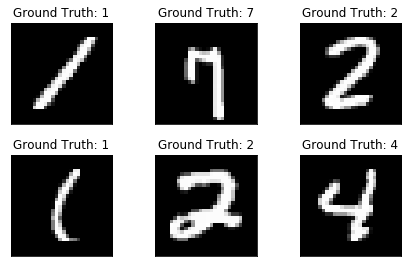

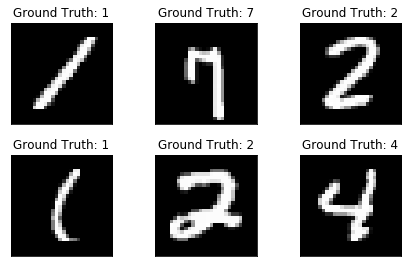

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [17]:
example_data.shape

torch.Size([1000, 1, 28, 28])

## TEST 7

### INSTALLATION

In [19]:
! git clone https://github.com/OpenMined/PySyft.git

fatal: destination path 'PySyft' already exists and is not an empty directory.


In [20]:
cd PySyft

/content/PySyft


In [21]:
! git checkout 7b6f9fb

M	syft/frameworks/torch/tensors/interpreters/native.py
HEAD is now at 7b6f9fb2 Merge pull request #2303 from amit-rastogi/dev


In [22]:
! git show

commit 7b6f9fb2b98865f4ad45f93d337970c885ee3534 (HEAD)
Merge: ab75db1e 0273a8f1
Author: Robert (Bobby) Wagner <raw141@case.edu>
Date:   Thu Jun 20 14:52:49 2019 -0400

    Merge pull request #2303 from amit-rastogi/dev
    
    Added tutorial for using pysyft to train a reinforcement learning agent



In [23]:
! pip install -r requirements.txt

In [24]:
cd ..

/content


In [0]:
! mv native.py PySyft/syft/frameworks/torch/tensors/interpreters/

In [26]:
cd PySyft/

/content/PySyft


In [27]:
! python3 setup.py install

running install
running bdist_egg
running egg_info
writing syft.egg-info/PKG-INFO
writing dependency_links to syft.egg-info/dependency_links.txt
writing requirements to syft.egg-info/requires.txt
writing top-level names to syft.egg-info/top_level.txt
writing manifest file 'syft.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
copying syft/frameworks/torch/tensors/interpreters/native.py -> build/lib/syft/frameworks/torch/tensors/interpreters
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/test
copying build/lib/test/test_serde.py -> build/bdist.linux-x86_64/egg/test
creating build/bdist.linux-x86_64/egg/test/torch
creating build/bdist.linux-x86_64/egg/test/torch/differential_privacy
copying build/lib/test/torch/differential_privacy/__init__.py -> build/bdist.linux-x86_64/egg/test/torch/differential_privacy
copying build/lib/test/torch/differential_privacy/test_pate.py -> build/bdist.linux-x86_6

In [28]:
! git clone https://github.com/tf-encrypted/tf-encrypted

fatal: destination path 'tf-encrypted' already exists and is not an empty directory.


In [33]:
cd tf-encrypted/

/content/PySyft/tf-encrypted


In [35]:
! pip3 install -e .

Obtaining file:///content/PySyft/tf-encrypted
  Found existing installation: tf-encrypted 0.5.6
    Uninstalling tf-encrypted-0.5.6:
      Successfully uninstalled tf-encrypted-0.5.6
  Running setup.py develop for tf-encrypted


In [36]:
import tf_encrypted as tfe

W0708 09:34:01.363904 140491739932544 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/content/PySyft/tf-encrypted/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0708 09:34:01.420444 140491739932544 deprecation_wrapper.py:119] From /content/PySyft/tf-encrypted/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [37]:
cd ..

/content/PySyft


In [29]:
import syft as sy

W0708 13:29:02.946363 140322888656768 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/content/PySyft/tf-encrypted/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0708 13:29:02.962099 140322888656768 deprecation_wrapper.py:119] From /content/PySyft/tf-encrypted/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
#import syft as sy  # <-- NEW: import the Pysyft library
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker bob
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice

### NoPeekNN

In [0]:
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 1000
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.log_interval = 30
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

if use_cuda:
        # TODO Quickhack. Actually need to fix the problem moving the model to CUDA\n",
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")
#device = torch.device("cpu")

#kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
kwargs = {'num_workers': 0, 'pin_memory': False} if use_cuda else {}

In [35]:
federated_train_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
    .federate((bob, alice)), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)


KeyboardInterrupt: ignored

In [0]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.max_pool2d(x, 2, 2)

In [0]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [0]:
models = [Net1().to(device), Net1().to(device)]
#models = [Net1(), Net1()]
models[0] = models[0].send(bob)
models[1] = models[1].send(alice)



opt1 = optim.SGD(params=models[0].parameters(),lr=0.1)
opt2 = optim.SGD(params=models[1].parameters(),lr=0.1)

In [0]:
def train(args, model, device, federated_train_loader, optimizer, epoch, alpha1=0.1,alpha2=0.9):
    model.train()
    for batch_idx, (data, targs) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        #IF ON DATA LOCATION TO GET THE RIGHT MODEL
        if data.location.id == 'bob':
          mod_c,opt_c = models[0], opt1
        else : 
          mod_c,opt_c = models[1], opt2
        
        #print("data",data.clone().get().size())
       # 1) erase previous gradients (if they exist)
        optimizer.step()
        opt_c.step()
        opt_c.zero_grad()
        optimizer.zero_grad()
        
        tg_copy = targs.copy()
        target = tg_copy.get()
        data, target = data.to(device), target.to(device)
        
        # 2) make a prediction until cut layer (client location)
        pred_c = mod_c(data)
        copy = pred_c.copy()
        

        
        
        # 3) get this to the server 
        inp = copy.get()

        # compute the distance correlation
        dist = batch_dcor(data.clone().get(),inp)
        dist.backward()
        
        
        # 4) make prediction with second part of the model (server location)
        pred = model(inp)

        # 5) calculate how much we missed 
        loss = F.nll_loss(pred, target)
        loss.backward()
        print(dist.grad)
        print(inp.grad)
        gradient = alpha1*dist.grad + alpha2*inp.grad
        gradient = gradient.send(data.location)
        dist.backward()
        pred_c.backward(gradient)
        
        
        if batch_idx % args.log_interval == 0:
            #loss = loss.get() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tDCor:'.format(
                epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
                100. * batch_idx / len(federated_train_loader), loss.item(),dist))

In [0]:
def train(args, model, device, federated_train_loader, optimizer, epoch, alpha1=0.1,alpha2=0.9):
    model.train()
    for batch_idx, (data, targs) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        #IF ON DATA LOCATION TO GET THE RIGHT MODEL
        if data.location.id == 'bob':
          mod_c,opt_c = models[0], opt1
        else : 
          mod_c,opt_c = models[1], opt2
        
        #print("data",data.clone().get().size())
        # 1) erase previous gradients (if they exist)
        optimizer.step()
        opt_c.step()
        opt_c.zero_grad()
        optimizer.zero_grad()
        
        tg_copy = targs.copy()
        target = tg_copy.get()
        data, target = data.to(device), target.to(device)
        
        # 2) make a prediction until cut layer (client location)
        pred_c = mod_c(data)
        copy = pred_c.copy()
        
        
        # 3) get this to the server 
        inp = copy.get()

        # compute the distance correlation
        print(data.shape)
        dist = batch_dcor(data,pred_c)
        dist.backward()
        
        
        # 4) make prediction with second part of the model (server location)
        pred = model(inp)

        # 5) calculate how much we missed 
        loss = F.nll_loss(pred, target)
        loss.backward()
        print(dist.grad)
        print(inp.grad)
        #gradient = alpha1*dist.grad + alpha2*inp.grad
        gradient = inp.grad
        gradient = gradient.send(data.location)
        dist.backward()
        pred_c.backward(gradient)
        
        
        if batch_idx % args.log_interval == 0:
            #loss = loss.get() # <-- NEW: get the loss back
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tDCor:'.format(
                epoch, batch_idx * args.batch_size, len(federated_train_loader) * args.batch_size,
                100. * batch_idx / len(federated_train_loader), loss.item(),dist))

In [0]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    M1 = models[0].copy()
    M2 = models[1].copy()
    M1 = M1.get()
    M2 = M2.get()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(M1(data))
            #output2 = model(M2(data))
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [100]:
%%time
model = Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr) # TODO momentum is not supported at the moment

for epoch in range(1, args.epochs + 1):
    train(args, model, device, federated_train_loader, optimizer, epoch)
    test(args, model, device, test_loader)

if (args.save_model):
    torch.save(model.state_dict(), "mnist_cnn.pt")

torch.Size([64, 1, 28, 28])
N= 64
torch.Size([64, 784])


RuntimeError: ignored

In [0]:
Q = torch.zeros(3,3)

In [0]:
c = torch.tensor(1.)

In [103]:
Q

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [0]:
Q[1,1]=c

In [105]:
c.shape

torch.Size([])

In [106]:
Q

tensor([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]])

In [1]:
1

1

In [1]:
! python3 --version

Python 3.6.8


In [0]:
def fonc(a,
        b,
        c,
        d,
        ):
  return a*b +c-d

In [3]:
fonc(1,2,3,4)

1

In [4]:
# Installation + Imports 
! git clone https://github.com/OpenMined/PySyft.git 
% cd PySyft
#! git checkout @{30.days.ago} # 30 days when 26th June
#! git checkout d126b3110a3970bef8932ffaf8987ba77d32deb1 .
! git checkout 7b6f9fb
! pip install -r requirements.txt
% cd .. 
! mv native.py PySyft/syft/frameworks/torch/tensors/interpreters/ 
% cd PySyft
! python3 setup.py install 


import syft as sy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time

Cloning into 'PySyft'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 29888 (delta 21), reused 22 (delta 9), pack-reused 29844
Receiving objects: 100% (29888/29888), 32.37 MiB | 20.21 MiB/s, done.
Resolving deltas: 100% (19905/19905), done.
/content/PySyft
Note: checking out '7b6f9fb'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 7b6f9fb2 Merge pull request #2303 from amit-rastogi/dev
     |████████████████████████████████| 389kB 14.4MB/s 
     |████████████████████████████████| 256kB 51.7MB/s 
     |█████████████████

W0730 13:44:33.990236 139716123875200 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0730 13:44:34.005762 139716123875200 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time

In [0]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.max_pool2d(x, 2, 2)

In [0]:
model = Net1()

In [9]:
for p in model.parameters():
  print(p[0][0][0][0].nelement())

1


IndexError: ignored

In [0]:
a=torch.tensor([1,2])

In [3]:
a.element_size()

8

In [4]:
a.nelement()

2

In [5]:
a.dtype

torch.int64

In [0]:
b = torch.tensor([1.,2.])

In [7]:
b.element_size()

4

In [8]:
b.dtype

torch.float32

In [9]:
b.nelement()

2

In [18]:
for p in model.parameters():
  print(p.element_size(),p.nelement())

4 500
4 20


In [0]:
import matplotlib.pyplot as plt

In [0]:
import numpy as np

In [0]:
X = np.arange(0.6,100,0.2)

In [0]:
Y1 = 1/X+1

In [0]:
Y2 = 2/X

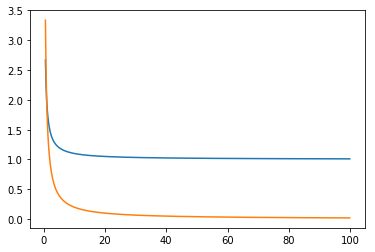

In [22]:
plt.plot(X,Y1)
plt.plot(X,Y2)
plt.show()